# Семинар 1. Обработка данных, визуализация и тривиальные модели.

## Обработка временных данных

Как мы уже поняли из предыдущей части, временные зависимости не сулят нам ничего хорошего при построении моделей. Аналогичная ситуация происходит и при обработке данных. Будем честны, далеко не во всех компаниях хранение данных реализовано хорошо и аккуратно. И временные ряды к таким неаккуратностям наиболее чувствительны. Как и в классических задачах машинного обучения, пропуски могу означать либо что значение непосредственно пропущенно,

Сегодня мы обсудим, как обрабатывать сырые данные. В общем и целом, они бывают двух видов: те, которые изначально собирались и хранились как временные ряда (более простой случай) и транзакционные данные, которые необходимо пердварительно агрегировать и преобразовать, чтобы получились временные ряды (более сложный случай). Рассмотрим сразу второй случай, он содержательнее

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)


In [8]:
# Читаем данные
data = pd.read_csv("data/sem_1/Retail_Data_Transactions.csv")
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [9]:
# Выберем индивида с самой длинной историей
data.groupby(by=['customer_id']).count()['tran_amount'].idxmax()

'CS4424'

В первую очередь необходимо привести индекс к правильному формату для того, чтобы было возможно эффективно оперировать с датами.

In [10]:
sample = data.groupby(by=['customer_id', 'trans_date']).sum().loc['CS4424']
# Изначально индекс -- в формате строк
sample.index

Index(['01-Dec-11', '01-Nov-12', '04-Jul-12', '04-Jul-13', '04-Oct-12',
       '04-Oct-14', '08-May-13', '10-Feb-14', '10-Mar-13', '10-Sep-11',
       '11-Apr-13', '11-Mar-13', '11-May-14', '13-Feb-13', '13-Mar-14',
       '15-Dec-14', '16-Mar-14', '16-May-13', '17-Apr-13', '17-Apr-14',
       '19-Aug-11', '19-Jan-15', '20-Nov-11', '24-Dec-14', '25-Aug-11',
       '25-Dec-13', '25-May-11', '26-Feb-14', '26-Mar-14', '27-Apr-13',
       '27-Jul-13', '28-Dec-12', '28-Dec-14', '28-Oct-14', '29-Apr-14',
       '29-Jan-12', '29-Nov-11', '30-Apr-13'],
      dtype='object', name='trans_date')

In [11]:
sample

,tran_amount
trans_date,
01-Dec-11,47
01-Nov-12,99
04-Jul-12,36
04-Jul-13,57
04-Oct-12,97
04-Oct-14,96
08-May-13,81
10-Feb-14,54
10-Mar-13,176


Переведём индекс в формат datetime. Это специальный формат, характеризующий точку во времени

In [12]:
# Переведём в формат datetime
sample.index = pd.to_datetime(sample.index)
sample.index

DatetimeIndex(['2011-12-01', '2012-11-01', '2012-07-04', '2013-07-04',
               '2012-10-04', '2014-10-04', '2013-05-08', '2014-02-10',
               '2013-03-10', '2011-09-10', '2013-04-11', '2013-03-11',
               '2014-05-11', '2013-02-13', '2014-03-13', '2014-12-15',
               '2014-03-16', '2013-05-16', '2013-04-17', '2014-04-17',
               '2011-08-19', '2015-01-19', '2011-11-20', '2014-12-24',
               '2011-08-25', '2013-12-25', '2011-05-25', '2014-02-26',
               '2014-03-26', '2013-04-27', '2013-07-27', '2012-12-28',
               '2014-12-28', '2014-10-28', '2014-04-29', '2012-01-29',
               '2011-11-29', '2013-04-30'],
              dtype='datetime64[ns]', name='trans_date', freq=None)

In [13]:
sample.index[0]

Timestamp('2011-12-01 00:00:00')

Чаще всего to_datetime сам справляется с парсингом дат, но иногда он это делает неверно. Если вручную специфицировать формат, то ошибок точно не будет.


In [14]:
pd.to_datetime("12-11-2010 10:00", format="%d-%m-%Y %H:%M")

Timestamp('2010-11-12 10:00:00')

Внимание! При парсинге числовой записи без формата по дефолту используется американская запись даты: месяц - день - год

In [15]:
pd.to_datetime("12-11-2010 10:00").day

11

Чтобы этого избежать используюте dayfirst = True. А лучше всегда пишите формат на всякий случай, "явное лучше неявного".

In [16]:
pd.to_datetime("12-11-2010 10:00", dayfirst=True).day

12

При более явных форматах такого, конечно, не происходит

In [17]:
pd.to_datetime('24-Dec-14').day

24

Также часто бывают ситуации, когда отдельные компоненты даты разнесены в разные столбцы. Это также не проблема. Если подать в to_datetime датафрейм со специальными именами столбцов, то он преобразует его в единый pd.Series.

Обязательные столбцы: year, month, day
Опциональные столбцы: hour, minute, second, millisecond, microsecond, nanosecond

In [18]:
df = pd.DataFrame(
    {"year": [2015, 2016], "month": [2, 3], "day": [4, 5], "hour": [2, 3]}
)
df

,year,month,day,hour
0,2015,2,4,2
1,2016,3,5,3


In [19]:
pd.to_datetime(df)

0   2015-02-04 02:00:00
1   2016-03-05 03:00:00
dtype: datetime64[ns]

Также для невалидных дат есть специальное обозначение -- NaT (Not a Timestamp)

In [20]:
pd.to_datetime([None])

DatetimeIndex(['NaT'], dtype='datetime64[ns]', freq=None)

## Периодичность 

Мы плавно подошли к первой важной характеристике временного ряда -- периодичности. Наш ряд -- последовательность некоторых значений в моменты времени. Но вообще поставщик данных нам не всегда гарантирует, что наши данные были собраны в равные промежутки времени (день, месяц, год и т.п.). Следовательно, данные можно разделить на периодические (то есть повторяющиеся через регулярные промежутки времени) и непериодические, которые ещё часто называют спорадическими. В нашем курсе мы скорее всего не будем рассматривать спорадические ряды.

У временных данных существует частотность (frequency). Она характеризует количество периодов между эквивалентными по календарным правилам точками и можно выразить численно. У годовых данных она равняется единице, у месячных -- 12, у дневных -- 365.366, 30/31 и 7, ну и так далее.

Как легко заметить, данные у нас непериодичные. Нам даны транзакции за какие-то дни в разных месяцах. Можем попытаться исправить это дело, перейдя к более "высокому" периоду. Например, перейдём к месячным данным. Для такого перехода необходимо выбрать способ, которым мы будем агрегировать данные. Если у нас есть данные за несколько дней в месяце, то надо решить, как они будут характеризовать значение за месяц. Пожно просуммировать, можно усреднить, и т.д. Выбирайте подходящий способ в зависимости от вашей задачи. 

Вообще говоря, подобный финт -- палка о двух концах. В случае спорадических данных он сработает только если их достаточно много и промежутки между наблюдениями невелики. Например, если наблюдения почасовые, но на каждый день есть хотя бы одно наблюдение. Иначе, очевидно, возникнут дыры в периодах, для которых не нашлось точек. Как можно видеть ниже, мы попытались перейти к неделям, и куча недель получились пустыми

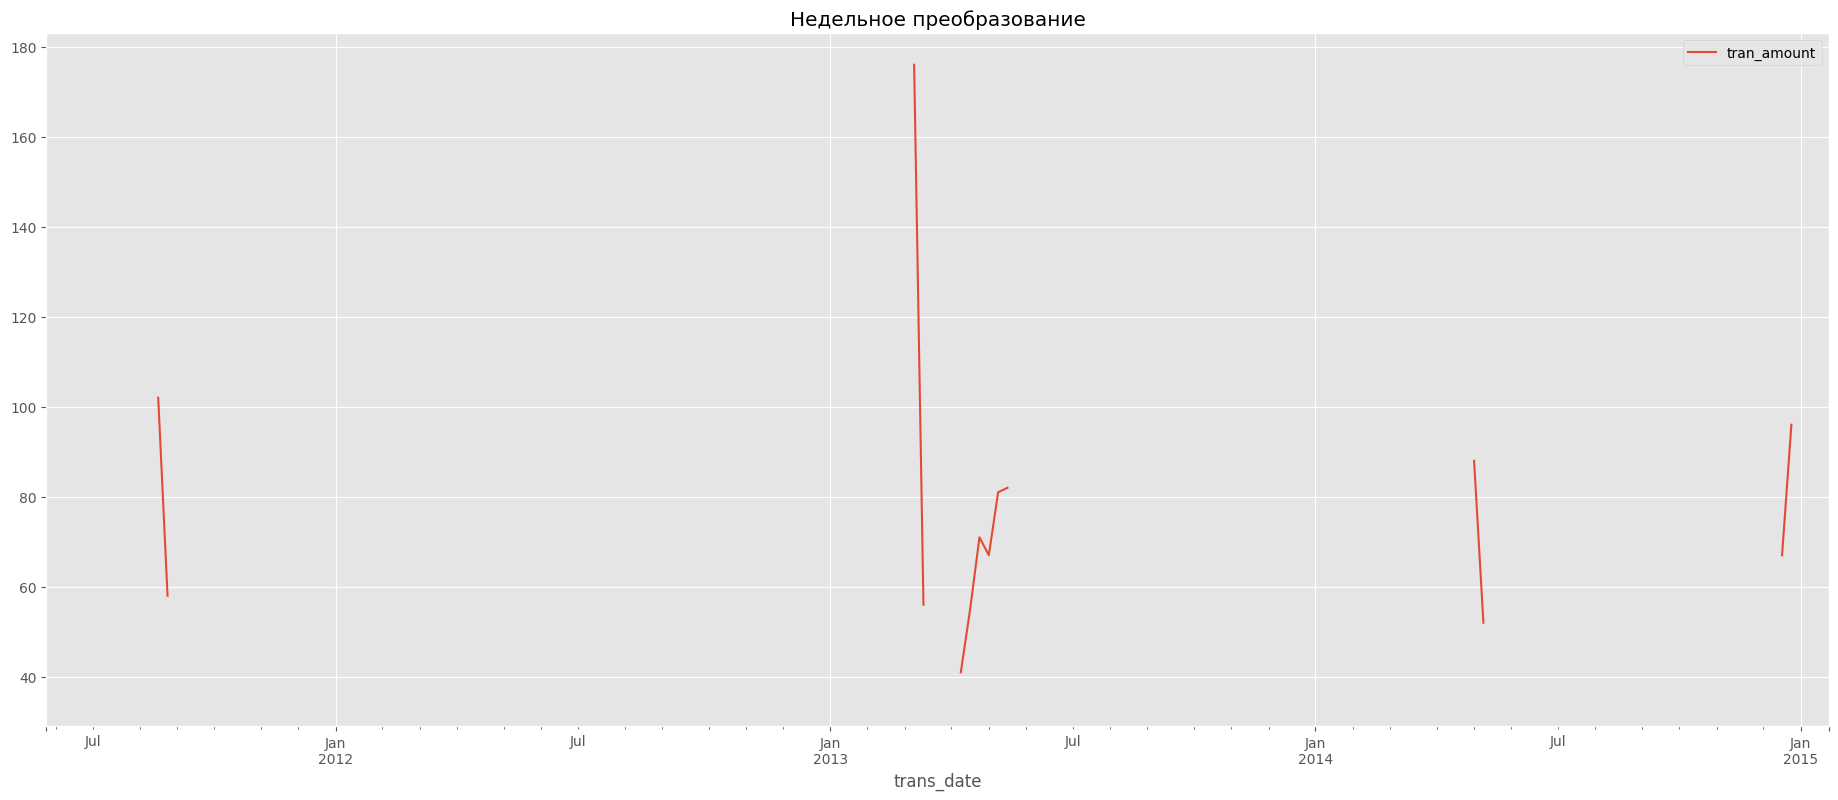

In [21]:
sample.resample("W").mean().plot()
plt.title('Недельное преобразование');


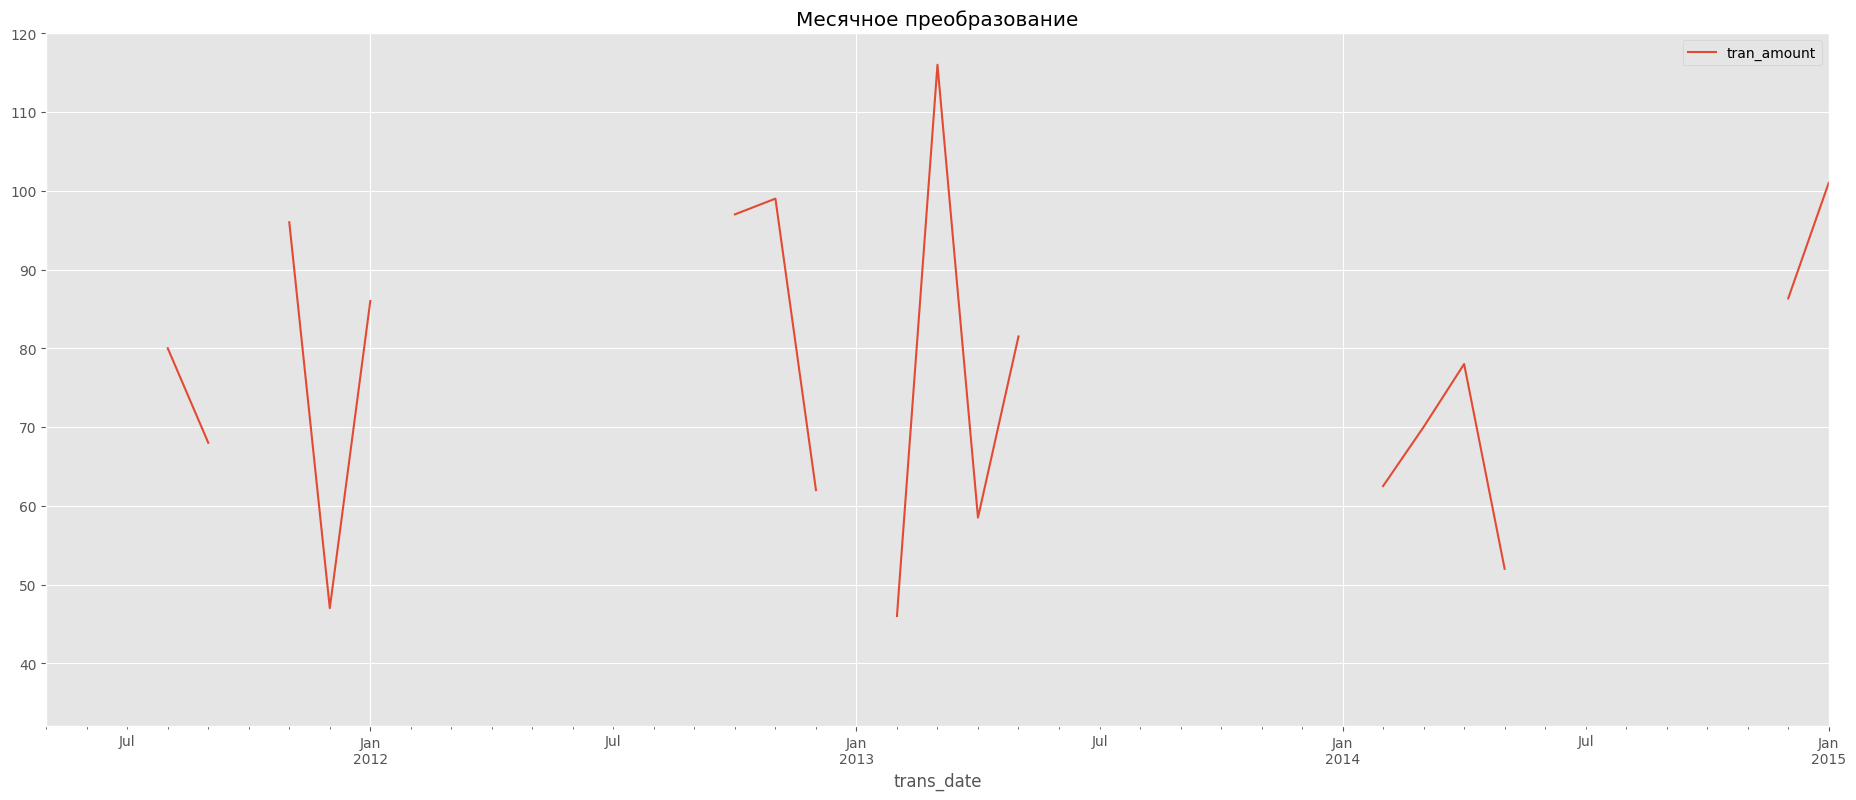

In [22]:
sample.resample("M").mean().plot()
plt.title('Месячное преобразование');

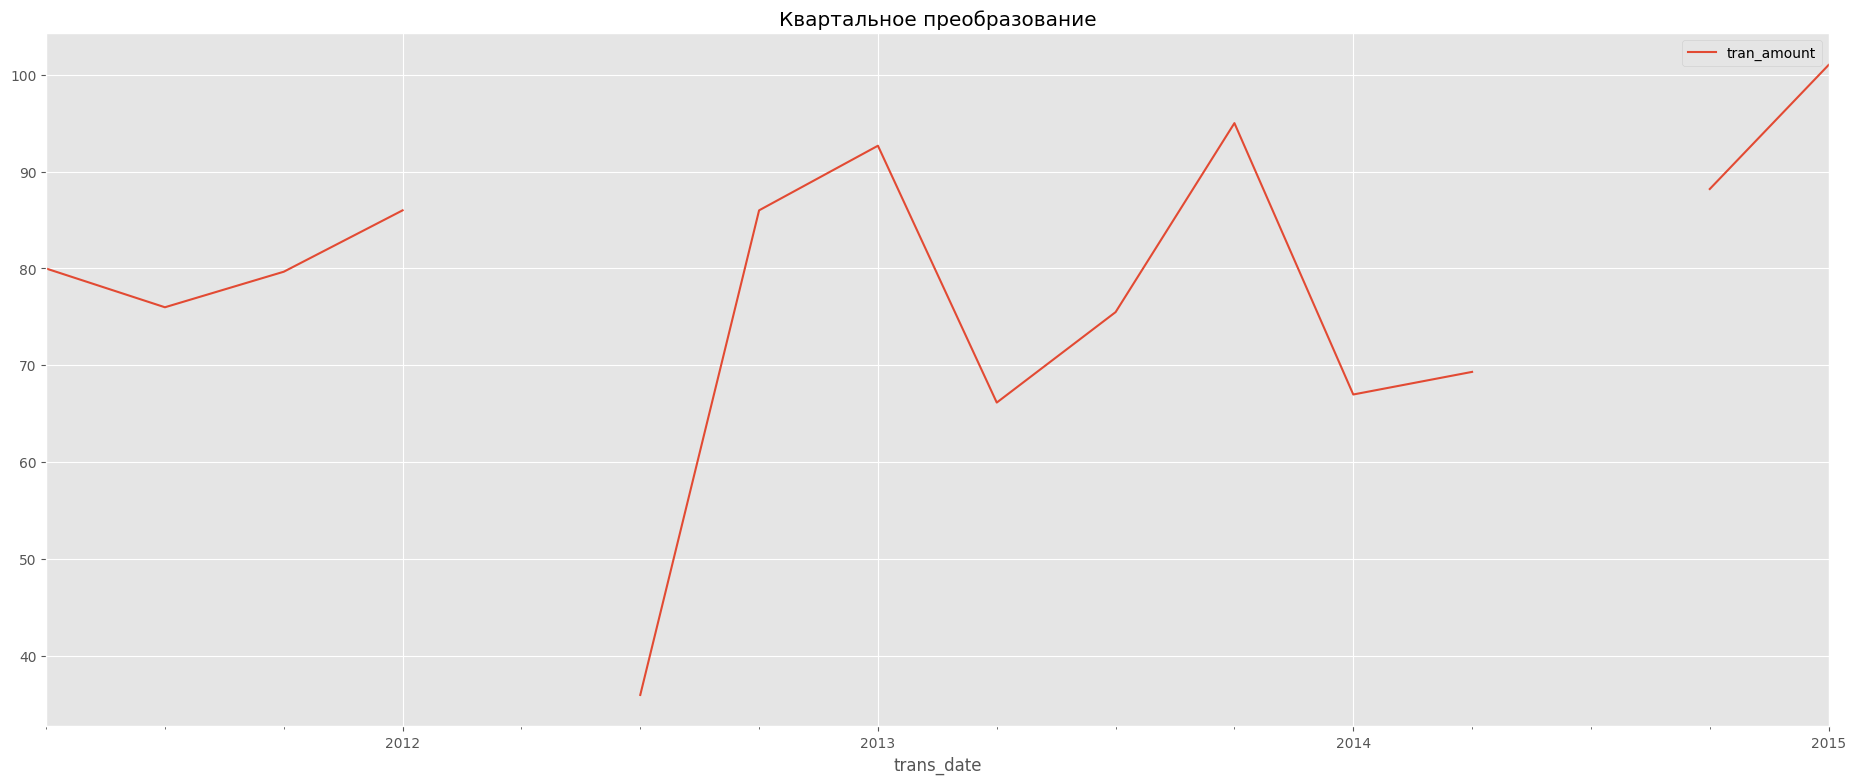

In [23]:
sample.resample("Q").mean().plot()
plt.title('Квартальное преобразование');

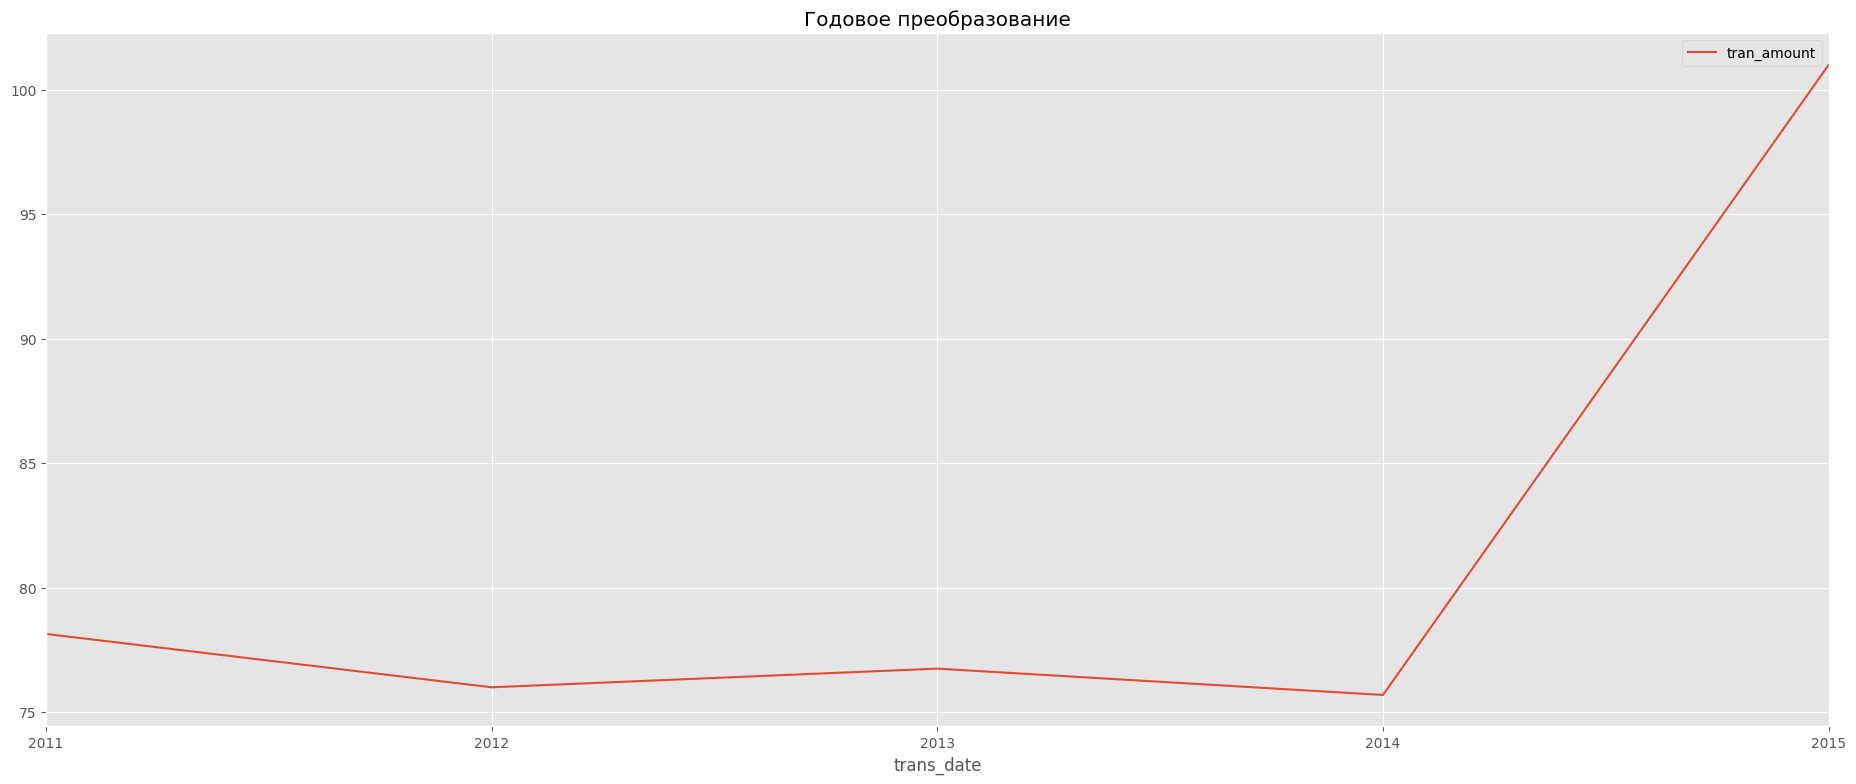

In [24]:
sample.resample("Y").mean().plot()
plt.title('Годовое преобразование');

Как мы видим, агрегация позволила сделать из непериодичных данных периодичные, но при этом данных осталось очень мало. Этот пример скорее иллюстративный. В такой ситуации скорее нужно искать альтернативную модель для работы со спорадическими данныи, чем агрегировать.

На самом деле, можно сделать такое преобразование и с периодичными данным -- просто чтобы понизить гранулярность ваших данных. Это может быть удобно и/или требоваться по задаче. Например, если наблюдения за объёмами продаж некоторого товара есть на каждый час, то просуммировать на дни вполне логично. Особенно если есть наблюдения за много дней. 

## Выравнивание

Данные с идеальной периодичностью это обычно уже подготовленные датасеты. Например, с соревнований. Так или иначе, они обычно уже агрегированны. В реальности это скорее мечта чем данность. 

Я по долгу службы много работал с публикациями ценовых котировок удобрений и всякой химии. Данные обычно предполагались недельными и публиковались в определённые дни. Например, многие источники публиковали данные по четвергам. Однако из-за праздников или просто проблем издателя данные иногда публиковались в среду, пятницу или вообще как попало. Моей задачей было агрегировать данные из разных источников и свести их к единой сетке. Для этого пришлось написать ряд эвристик.

In [196]:
dates =  pd.date_range(
        '01.01.2024', periods=100, freq="W"
    ).values

import numpy as np

updated_dates = []

for i, date in enumerate(dates):



    if i > 50:
        date = date +  pd.DateOffset(days=1)

    if i < 40 or i > 60:
        updated_dates.append(date)

    

dates = pd.DatetimeIndex(updated_dates)


TODO: Этот класс как-то неуместно смотрится, надо придумать как интегрировать.

In [197]:
from typing import Iterable 

from datetime import datetime
from enum import Enum

from operator import itemgetter
from pandas.tseries.frequencies import to_offset


class DateError(Exception):
    pass

class Offset:
    def __init__(
        self,
        delta: pd.DateOffset | None,
        conversion_rule: str | None,
      
    ):
        self.delta = delta
        self.conversion_rule = conversion_rule

    def get_rule_obj(self) -> pd.DateOffset:
        if self.conversion_rule is None:
            raise ValueError("Irregular series don't have conversion rule")
        else:
            try:
                rule_object = to_offset(self.conversion_rule)
                return rule_object

            except ValueError as e:
                raise NotImplementedError(
                    f"Conversion rule {self.conversion_rule} is not implemented"
                )
class Frequency(Enum):
   
    IRREGULAR = Offset(delta=None, conversion_rule=None)
    D =  Offset(delta=pd.DateOffset(days=1), conversion_rule="D")
    W_MON = Offset(delta=pd.DateOffset(weeks=1), conversion_rule="W-MON")
    W_TUE = Offset(delta=pd.DateOffset(weeks=1), conversion_rule="W-TUE")


    def align_dates(self, dates: pd.DatetimeIndex) -> pd.DatetimeIndex:
        assert type(dates) is pd.DatetimeIndex, (self, dates)

        match self:
            case Frequency.IRREGULAR, Frequency.D:
                return dates

            case _:
                try:
                    self.ensure(dates, check_deltas=True)
                    return dates

                except DateError:
                    date_range = pd.date_range(
                        dates.min() - pd.DateOffset(months=1),
                        dates.max() + pd.DateOffset(months=1),
                        freq=self.value.conversion_rule,
                    )

                    result = pd.Series(pd.NA, index=dates)

                    for i in [0, -1, 1, -2, 2, -3, 3, -4, +4]:
                        if dates.empty:
                            break

                        shifted_dates: pd.DatetimeIndex = dates + pd.offsets.Day(n=i)

                        shifted_data = pd.DataFrame(
                            {"origin_date": dates},
                            index=shifted_dates,
                        )

                        date_intersection = shifted_data.index.intersection(date_range)

                        origin_dates = shifted_data.loc[
                            date_intersection, "origin_date"
                        ].values

                        result.loc[origin_dates] = date_intersection

                        dates = result.loc[result.isna()].index
                        date_range = date_range.difference(date_intersection)

                    if not dates.empty or result.isna().any():
                        raise DateError(
                            f"Some dates were not converted. Frequency: {self.name}, dates: {dates.to_list()}\n\n: {result}"
                        )

                    # return result
                    return pd.DatetimeIndex(result.values)

    def ensure(
        self,
        array: Iterable[datetime],
        target_array: Iterable[datetime] | None = None,
        check_deltas=False,
    ) -> None:
        if target_array is not None:
            assert len(array) == len(
                target_array
            ), "Length of two arrays have to be equal"

        if self == Frequency.IRREGULAR:
            raise DateError("Ensuring irregular frequency is not supported")

        rule_object = self.value.get_rule_obj()
        # Checking if dates are from the given frequency
        is_not_correct = [
            i for i, date in enumerate(array) if not rule_object.is_on_offset(date)
        ]

        if is_not_correct:
            incorrect_dates = (
                itemgetter(*is_not_correct)(array)
                if len(is_not_correct) > 1
                else [array[0]]
            )

            incorrect_dates_str = ", \n".join(
                [date.strftime("%Y-%m-%d") for date in incorrect_dates]
            )

            raise DateError(
                f"Data contains dates that are not from the given frequency: \n\n{incorrect_dates_str}"
            )

        if check_deltas:
            # Checking the difference between dates
            # All dates has to have same delta (or x deltas) between

            # Comparing vector to itself fi target array is not proposed
            start_index = 1 if target_array is None else 0
            for i in range(start_index, len(array)):
                source_date = array[i - 1] if target_array is None else array[i]
                target_date = array[i] if target_array is None else target_array[i]
                updated_date = source_date

                # If previous date equal to current date, the timeline is invalid
                if source_date == target_date:
                    raise DateError(f"The following date is duplicated: {target_date}")

                ok = False
                # Going from updated date to current date
                while updated_date <= target_date:
                    # At each step adding delta of current frequency
                    updated_date += self.value.delta

                    # If dates are equal, then difference between them is correct
                    if updated_date == target_date:
                        ok = True

                # If update date overflow current date, then it's incorrect
                if not ok:
                    raise DateError(
                        f"The following subsequent dates are not consistent with frequency {self.name}: {source_date}, {target_date}"
                    )

    def get_ensure_percentage(self, array: Iterable[datetime], check_deltas=False) -> float:
        num_pairs = len(array) - 1

        num_valid = 0

        # For each pair of dates
        for i in range(num_pairs):
            j = i + 1

            pair = [array[i], array[j]]

            # try to ensure that pair is valid
            try:
                self.ensure(pair, check_deltas=check_deltas)

                # if pair is valid, add counter
                num_valid += 1

            except DateError:
                pass

        return num_valid / num_pairs

    def get_denominator_percentage(
        self, array: Iterable[datetime], day_delta: int
    ) -> float:
        num_pairs = len(array) - 1

        num_valid = 0

        # For each pair of dates
        for i in range(num_pairs):
            j = i + 1

            # try to ensure that pair is valid
            if not (array[j] - array[i]).days % day_delta:
                num_valid += 1

        return num_valid / num_pairs



In [198]:
dates

DatetimeIndex(['2024-01-07', '2024-01-14', '2024-01-21', '2024-01-28',
               '2024-02-04', '2024-02-11', '2024-02-18', '2024-02-25',
               '2024-03-03', '2024-03-10', '2024-03-17', '2024-03-24',
               '2024-03-31', '2024-04-07', '2024-04-14', '2024-04-21',
               '2024-04-28', '2024-05-05', '2024-05-12', '2024-05-19',
               '2024-05-26', '2024-06-02', '2024-06-09', '2024-06-16',
               '2024-06-23', '2024-06-30', '2024-07-07', '2024-07-14',
               '2024-07-21', '2024-07-28', '2024-08-04', '2024-08-11',
               '2024-08-18', '2024-08-25', '2024-09-01', '2024-09-08',
               '2024-09-15', '2024-09-22', '2024-09-29', '2024-10-06',
               '2025-03-10', '2025-03-17', '2025-03-24', '2025-03-31',
               '2025-04-07', '2025-04-14', '2025-04-21', '2025-04-28',
               '2025-05-05', '2025-05-12', '2025-05-19', '2025-05-26',
               '2025-06-02', '2025-06-09', '2025-06-16', '2025-06-23',
      

In [199]:
Frequency.W_MON.ensure(dates)

DateError: Data contains dates that are not from the given frequency: 

2024-01-07, 
2024-01-14, 
2024-01-21, 
2024-01-28, 
2024-02-04, 
2024-02-11, 
2024-02-18, 
2024-02-25, 
2024-03-03, 
2024-03-10, 
2024-03-17, 
2024-03-24, 
2024-03-31, 
2024-04-07, 
2024-04-14, 
2024-04-21, 
2024-04-28, 
2024-05-05, 
2024-05-12, 
2024-05-19, 
2024-05-26, 
2024-06-02, 
2024-06-09, 
2024-06-16, 
2024-06-23, 
2024-06-30, 
2024-07-07, 
2024-07-14, 
2024-07-21, 
2024-07-28, 
2024-08-04, 
2024-08-11, 
2024-08-18, 
2024-08-25, 
2024-09-01, 
2024-09-08, 
2024-09-15, 
2024-09-22, 
2024-09-29, 
2024-10-06

In [200]:
Frequency.W_MON.align_dates(dates)

DatetimeIndex(['2024-01-08', '2024-01-15', '2024-01-22', '2024-01-29',
               '2024-02-05', '2024-02-12', '2024-02-19', '2024-02-26',
               '2024-03-04', '2024-03-11', '2024-03-18', '2024-03-25',
               '2024-04-01', '2024-04-08', '2024-04-15', '2024-04-22',
               '2024-04-29', '2024-05-06', '2024-05-13', '2024-05-20',
               '2024-05-27', '2024-06-03', '2024-06-10', '2024-06-17',
               '2024-06-24', '2024-07-01', '2024-07-08', '2024-07-15',
               '2024-07-22', '2024-07-29', '2024-08-05', '2024-08-12',
               '2024-08-19', '2024-08-26', '2024-09-02', '2024-09-09',
               '2024-09-16', '2024-09-23', '2024-09-30', '2024-10-07',
               '2025-03-10', '2025-03-17', '2025-03-24', '2025-03-31',
               '2025-04-07', '2025-04-14', '2025-04-21', '2025-04-28',
               '2025-05-05', '2025-05-12', '2025-05-19', '2025-05-26',
               '2025-06-02', '2025-06-09', '2025-06-16', '2025-06-23',
      

In [201]:
dates

DatetimeIndex(['2024-01-07', '2024-01-14', '2024-01-21', '2024-01-28',
               '2024-02-04', '2024-02-11', '2024-02-18', '2024-02-25',
               '2024-03-03', '2024-03-10', '2024-03-17', '2024-03-24',
               '2024-03-31', '2024-04-07', '2024-04-14', '2024-04-21',
               '2024-04-28', '2024-05-05', '2024-05-12', '2024-05-19',
               '2024-05-26', '2024-06-02', '2024-06-09', '2024-06-16',
               '2024-06-23', '2024-06-30', '2024-07-07', '2024-07-14',
               '2024-07-21', '2024-07-28', '2024-08-04', '2024-08-11',
               '2024-08-18', '2024-08-25', '2024-09-01', '2024-09-08',
               '2024-09-15', '2024-09-22', '2024-09-29', '2024-10-06',
               '2025-03-10', '2025-03-17', '2025-03-24', '2025-03-31',
               '2025-04-07', '2025-04-14', '2025-04-21', '2025-04-28',
               '2025-05-05', '2025-05-12', '2025-05-19', '2025-05-26',
               '2025-06-02', '2025-06-09', '2025-06-16', '2025-06-23',
      

In [202]:
Frequency.W_MON.get_ensure_percentage(dates, check_deltas=False)

0.48717948717948717

In [203]:
Frequency.W_MON.get_denominator_percentage(dates, 7)

0.9871794871794872

TODO: Рассказать про пересмотр данных и несколько точек на один период. Например, пересмотр котировок.

TODO: Подумать, что ещё можно рассказать про особенности временных типов данных. (99% покрывается Timestamp)

В pandas можно генерировать индексы специального вида -- period. Этот тип данных в отличие от предыдущего характеризуетсяименно продолжительностью, а не точкой во времени. Периоды существуют множества видов -- день, конец месяца, начало месяца, начало квартала и т.д. Подробный список можно найти по [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#period-aliases). Этот список однако короче, чем тот, что для  [обычных Timestamp](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#period-aliases).


Timestamp можно конвертировать в period. Однако не 

In [26]:
pd.Timestamp("01.01.2002").to_period("M")

Period('2002-01', 'M')

In [208]:
pd.date_range("2018-01-01", periods=100, freq="H")

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               '2018-01-01 10:00:00', '2018-01-01 11:00:00',
               '2018-01-01 12:00:00', '2018-01-01 13:00:00',
               '2018-01-01 14:00:00', '2018-01-01 15:00:00',
               '2018-01-01 16:00:00', '2018-01-01 17:00:00',
               '2018-01-01 18:00:00', '2018-01-01 19:00:00',
               '2018-01-01 20:00:00', '2018-01-01 21:00:00',
               '2018-01-01 22:00:00', '2018-01-01 23:00:00',
               '2018-01-02 00:00:00', '2018-01-02 01:00:00',
               '2018-01-02 02:00:00', '2018-01-02 03:00:00',
               '2018-01-02 04:00:00', '2018-01-02 05:00:00',
               '2018-01-02 06:00:00', '2018-01-02 07:00:00',
               '2018-01-

## Характеристики рядов

In [172]:
import statsmodels.api as sm
data = sm.datasets.macrodata.load_pandas().data

In [20]:
#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
data.index = pd.date_range(start = '01.01.1959', periods = len(data), freq='Q')
display(data)
data = data.drop(columns = ['year', 'quarter'])

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


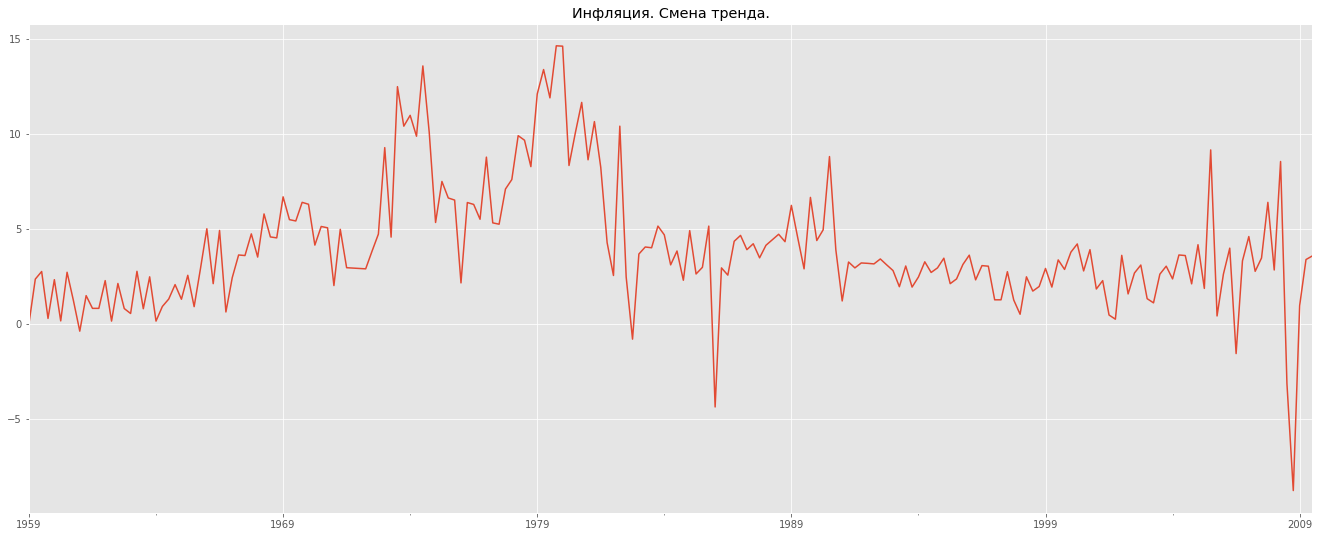

In [27]:
data.infl.plot()
plt.title('Инфляция. Смена тренда.');

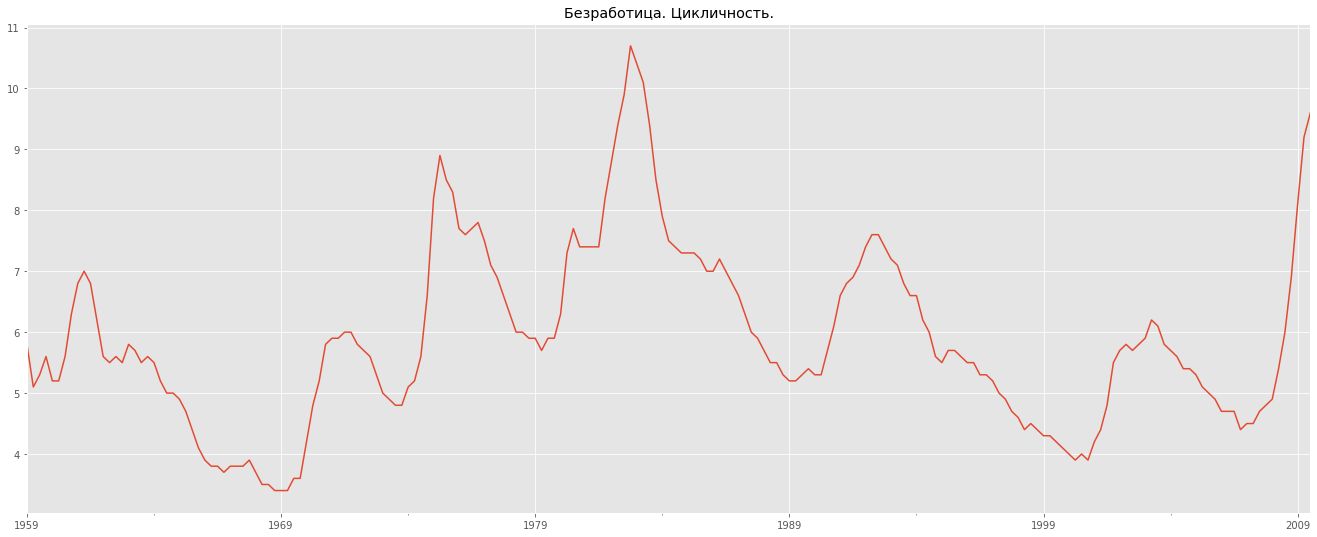

In [28]:
data.unemp.plot()
plt.title('Безработица. Цикличность.');

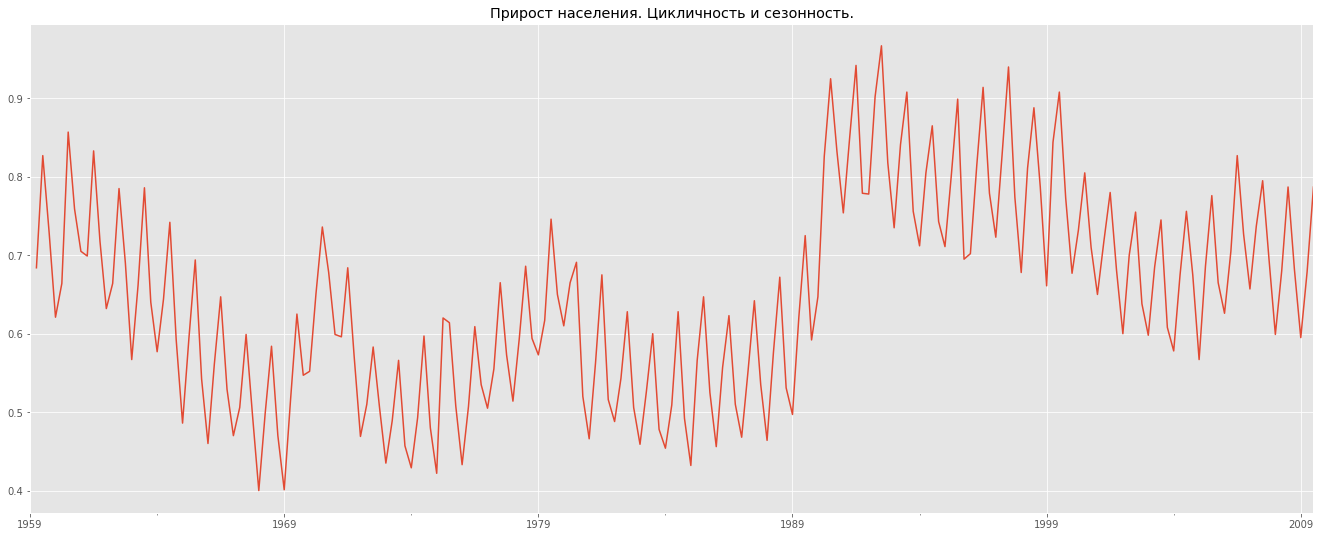

In [31]:
data.loc[:,'pop'].diff().plot()
plt.title('Прирост населения. Цикличность и сезонность.');

In [32]:
data.loc[:,'pop'].diff()

1959-03-31      NaN
1959-06-30    0.684
1959-09-30    0.827
1959-12-31    0.729
1960-03-31    0.621
              ...  
2008-09-30    0.787
2008-12-31    0.682
2009-03-31    0.595
2009-06-30    0.679
2009-09-30    0.787
Freq: Q-DEC, Name: pop, Length: 203, dtype: float64

## Стационарность

Одной из важнейших характеристик случайного процесса является стационарность. Различают два вида стационарности -- в широком и в узком смысле.  Случайный процесс $X_{t}$ называется стационарным (statiоnary, стационарным в узком смысле), если все его конечномерные распределения инвариантны относительно сдвигов, т.е. для любых наборов моментов времени $t_{1}, \ldots, t_{n}$, любых вещественных $x_{1}, \ldots, x_{n}$ и любого $h>0$,


$$\mathbb{P}\left\{X_{t_{1}} \leq x_{1}, \ldots, X_{t_{n}} \leq x_{n}\right\}=\mathbb{P}\left\{X_{t_{1}+h} \leq x_{1}, \ldots, X_{t_{n}+h} \leq x_{n}\right\}$$

Грубо говоря, совместные распределения на любых двух равных по длине временных отрезках равны друг другу. Но очевидно, что в реальной жизни такие процессы найти весьма сложно, хотя и очень хотелось бы. В определении слабой стационарности  (wide sense stationary, weakly stationary, covariance stationary, second-order stationary) предлагается ослабить предыдущее условие. Пусть постоянными во времени будут не все характеристики распределения, а только некоторые моменты. Так, если у случайного процесса математическое ожидание постоянно во времени, и кроме того, для любых $h>0, s, t \in \mathbb{R}$ выполнено

$$Cov(X_{t+h}, X_{s+h})=Cov(X_t, X_s)$$


то процесс является слабостационарным. То есть у всех точек равное математическое ожидание, равная дисперсия, а ковариации равны для точек, разнесённых на равные отрезки времени. Нетрудно заметить, что в случае гауссовских процессов из слабой стационарности может следовать сильная, но во всех остальных случаях -- только в обратную сторону.

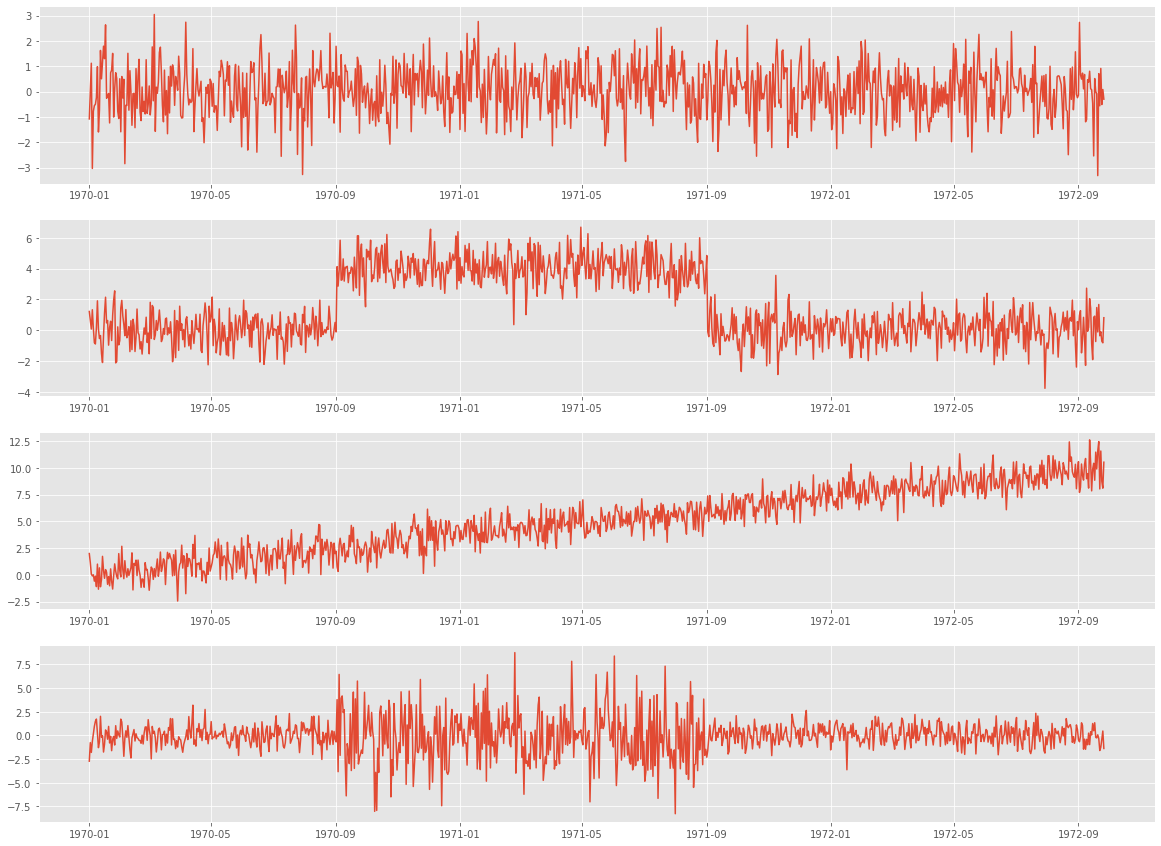

In [33]:
import numpy as np
n_sim = 1000
fig, ax = plt.subplots(nrows=4, figsize=(20,15))
index = pd.date_range(start='01.01.1970', periods=n_sim, freq='D')

ax[0].plot(pd.Series(np.random.normal(size=n_sim), index=index))
ax[1].plot(pd.Series(
    np.random.normal(size=n_sim) +
    (index > '1970-09') * 4 - 
    (index > '1971-09') * 4, 
    index=index))
ax[2].plot(pd.Series(np.random.normal(size=n_sim) + np.arange(n_sim)/100, index=index))

ax[3].plot(pd.Series(
    np.random.normal(scale=1 +
    (index > '1970-09') * 2 - 
    (index > '1971-09') * 2, size=n_sim) ,
    index=index))

## Корреляционные характеристики

У случайных процессов существует специальная характеристика, показывающая силу линейных взаимосвязей внутри них. Соответственно, по временным рядам (траекториям этих случайных процессов) мы можем построить оценки этих характеристик. Давайте поговорим о том, что они из себя представляют и как их вычислять.

Автокорреляцией k-го порядка будем называть величину $corr(y_t, y_{t-k})$. Самый простой способ оценить эту величину -- подсчитать выборочный коэффициент корреляции  $\hat{corr}(y_t, y_{t-k})$. Также можно построить парную регрессию и зять корень из коэффициента детерминации, но это будет ровно то же самое. Обычно вычисляют значения для значений $k \in \{1,\cdots,K\}$ и строят график. О том, как использовать информацию о линейных связях для построения моделей, мы поговорим позже. А пока взглянем на график ACF (Autocorrelation function)

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

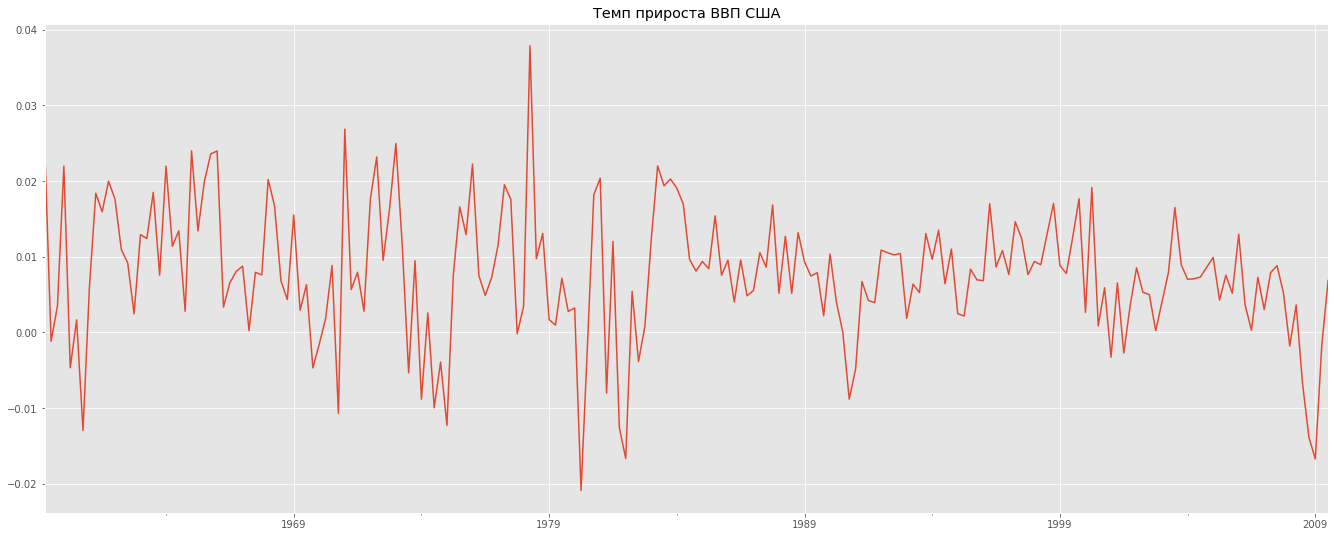

In [35]:
# Темп прироста ВВП
g_rate = (data.realgdp.diff() / data.realgdp).dropna()
g_rate.plot()
plt.title("Темп прироста ВВП США");

In [38]:
pd.DataFrame([
    data.realgdp, data.realgdp.shift(3)
]).T

,realgdp,realgdp
1959-03-31,2710.349,NaN
1959-06-30,2778.801,NaN
1959-09-30,2775.488,NaN
1959-12-31,2785.204,2710.349
1960-03-31,2847.699,2778.801
...,...,...
2008-09-30,13324.600,13391.249
2008-12-31,13141.920,13366.865
2009-03-31,12925.410,13415.266
2009-06-30,12901.504,13324.600


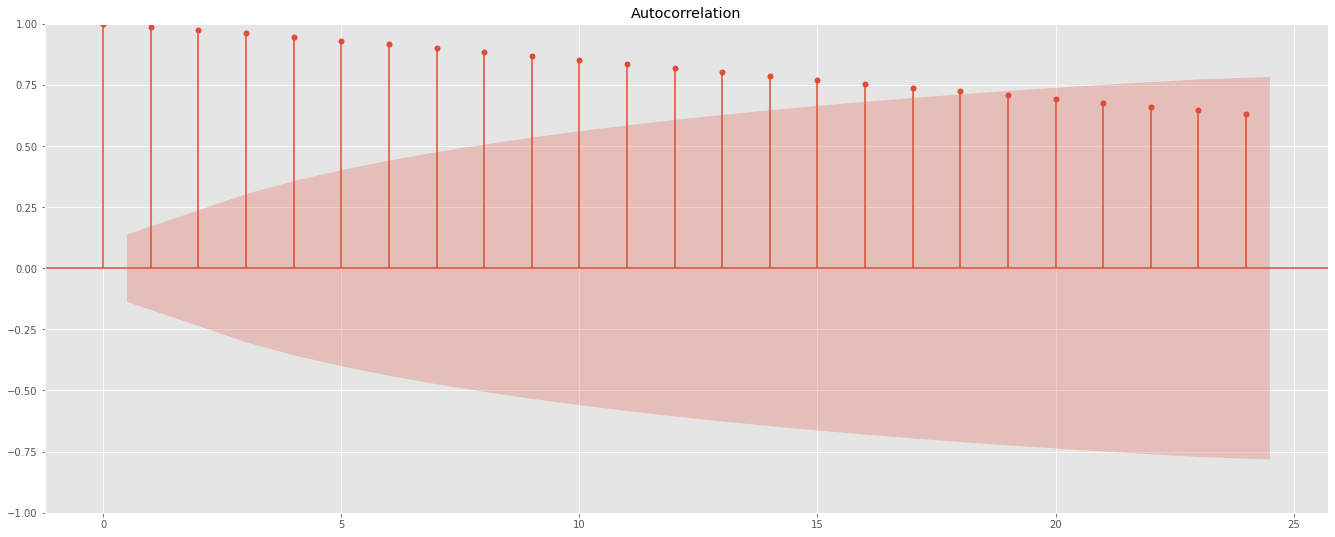

In [24]:
plot_acf(data.realgdp);

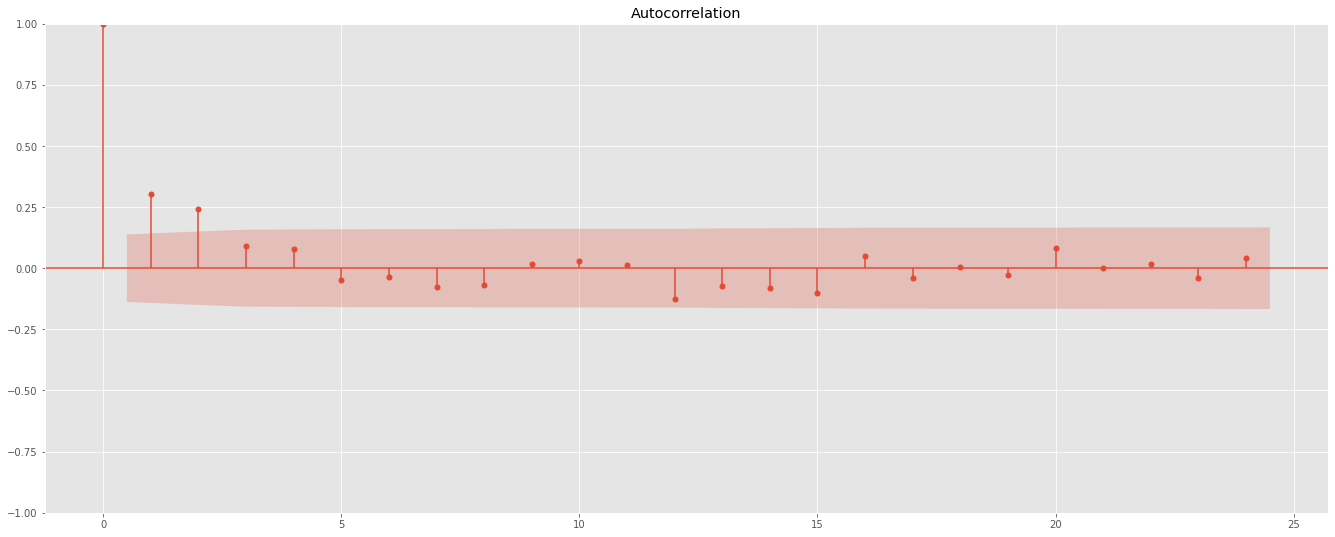

In [39]:
plot_acf(g_rate);

Вообще говоря, если мы взглянем на формулу автокорреляции, она может показаться неполной. Да, мы смотрим на связь переменной и её лагированного значения, но при этом не учитываем всё, что было между ними. Хотелось бы в дополнение к обычной корреляции знать и условную: $corr(y_t, y_{t-k}| y_{t-1}, y_{t-2}, \cdots, y_{t-k+1})$. Для её нахождения существуют разные методы. Из основных -- численное решение системы уравнений Yule-Walker  или построение регрессий (рассмотрим подробнее в контексте ARIMA). Нарисуема пару графиков PACF (Partial Autocorrelation Function)



In [40]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


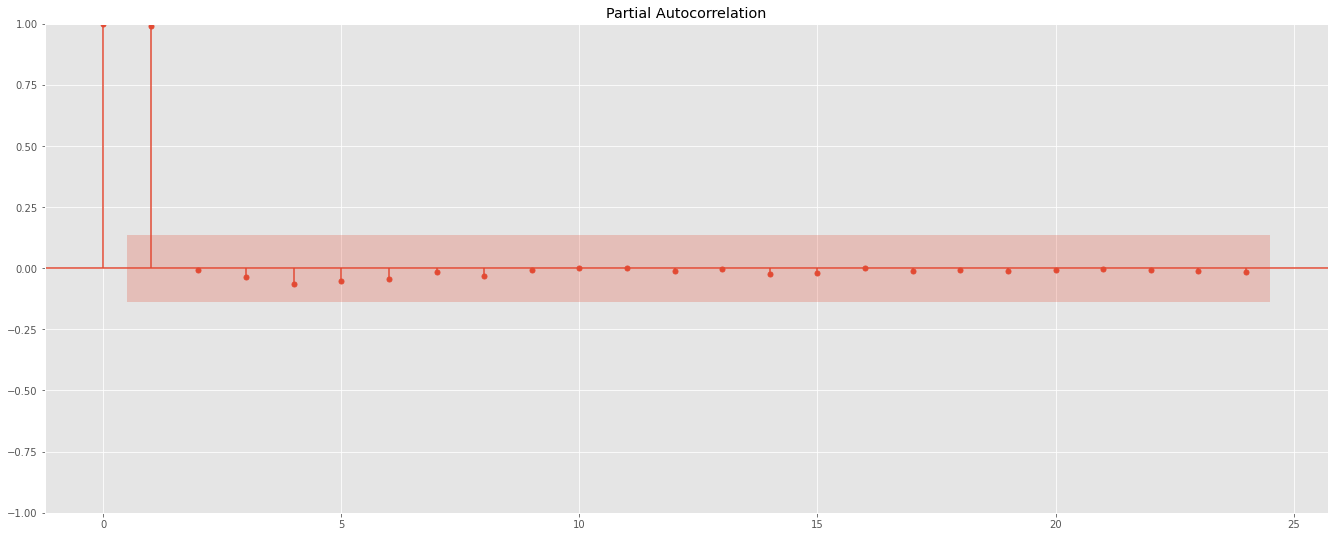

In [41]:
plot_pacf(data.realgdp);

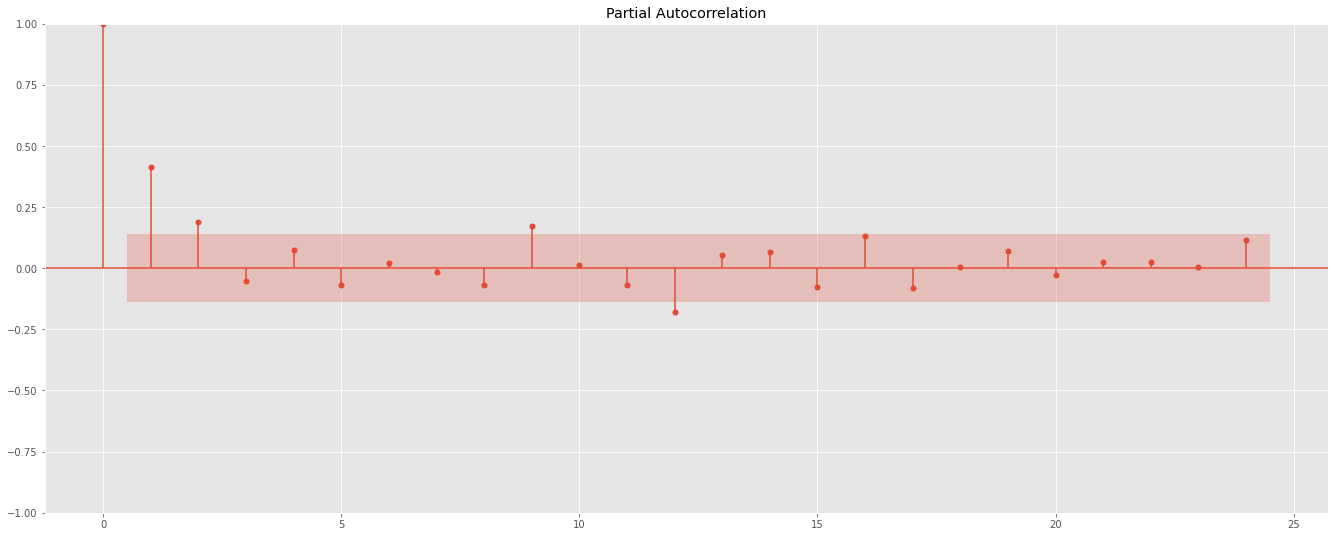

In [42]:
plot_pacf(data.realgdp.diff().dropna());